In [1]:
import uuid
from enum import Enum
from collections import Counter
import deprecation
from pm4py.util import constants
from graphviz import Digraph
from typing import Optional, Dict, Any, Union, Tuple
import graphviz
from pm4py.util import exec_utils
import tempfile
from pm4py.visualization.common import gview

# BPMN

Direkt Annotation és Association leszármazottakkal

In [2]:
DEFAULT_PROCESS = str(uuid.uuid4())


class Marking(Counter):
    pass

    # required = Counter()

    def __hash__(self):
        r = 0
        for p in self.items():
            r += 31 * hash(p[0]) * p[1]
        return r

    def __eq__(self, other):
        if not self.keys() == other.keys():
            return False
        for p in self.keys():
            if other.get(p) != self.get(p):
                return False
        return True

    def __le__(self, other):
        if not self.keys() <= other.keys():
            return False
        for p in self.keys():
            if sum(other.get(p)) < sum(self.get(p)):
                return False
        return True

    def __add__(self, other):
        m = Marking()
        for p in self.items():
            m[p[0]] = p[1]
        for p in other.items():
            m[p[0]] += p[1]
        return m

    def __sub__(self, other):
        m = Marking()
        for p in self.items():
            m[p[0]] = p[1]
        for p in other.items():
            m[p[0]] -= p[1]
            if m[p[0]] == 0:
                del m[p[0]]
        return m

    def __repr__(self):
        # return str([str(p.name) + ":" + str(self.get(p)) for p in self.keys()])
        # The previous representation had a bug, it took into account the order of the places with tokens
        return str([str(p.id) + ":" + str(self.get(p)) for p in sorted(list(self.keys()), key=lambda x: x.id)])

    def __deepcopy__(self, memodict={}):
        marking = Marking()
        memodict[id(self)] = marking
        for node in self:
            node_occ = self[node]
            new_node = memodict[id(node)] if id(node) in memodict else BPMN.BPMNNode(node.id, node.name)
            marking[new_node] = node_occ
        return marking


class BPMNNodeLayout(object):
    def __init__(self):
        self.__x = 0
        self.__y = 0
        self.__width = 100
        self.__height = 100

    def set_x(self, x):
        self.__x = x

    def set_y(self, y):
        self.__y = y

    def get_x(self):
        return self.__x

    def get_y(self):
        return self.__y

    def get_width(self):
        return self.__width

    def set_width(self, width):
        self.__width = width

    def get_height(self):
        return self.__height

    def set_height(self, height):
        self.__height = height


class BPMNEdgeLayout(object):
    def __init__(self):
        self.__waypoints = [(0, 0), (0, 0)]

    def add_waypoint(self, waypoint):
        self.__waypoints.append(waypoint)

    def del_waypoints(self):
        self.__waypoints = list()

    def get_waypoints(self):
        return self.__waypoints


class BPMNLayout(object):
    def __init__(self):
        self.layout_dict = {}

    def get(self, n):
        if n not in self.layout_dict:
            if isinstance(n, BPMN.BPMNNode):
                self.layout_dict[n] = BPMNNodeLayout()
            elif isinstance(n, BPMN.Flow):
                self.layout_dict[n] = BPMNEdgeLayout()
            #BCS
            elif isinstance(n, BPMN.TextAnnotation):
                self.layout_dict[n] = BPMNNodeLayout()
            elif isinstance(n, BPMN.Association):
                self.layout_dict[n] = BPMNEdgeLayout()
        return self.layout_dict[n]


class BPMN(object):
    class BPMNNode(object):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            self.__id = ("id" + str(uuid.uuid4())) if id == "" else id
            self.__name = name
            self.__in_arcs = list() if in_arcs is None else in_arcs
            self.__out_arcs = list() if out_arcs is None else out_arcs
            self.__process = DEFAULT_PROCESS if process == None else process
            self.__layout = BPMNLayout()

        def get_id(self):
            return self.__id

        def get_name(self):
            return self.__name

        def get_in_arcs(self):
            return self.__in_arcs

        def get_out_arcs(self):
            return self.__out_arcs

        def add_in_arc(self, in_arc):
            if in_arc not in self.__in_arcs:
                self.__in_arcs.append(in_arc)

        def add_out_arc(self, out_arc):
            if out_arc not in self.__out_arcs:
                self.__out_arcs.append(out_arc)

        def remove_in_arc(self, in_arc):
            self.__in_arcs.remove(in_arc)

        def remove_out_arc(self, out_arc):
            self.__out_arcs.remove(out_arc)

        def get_process(self):
            return self.__process

        def set_process(self, process):
            self.__process = process

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_x(self, x):
            return self.__layout.get(self).set_x(x)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_y(self, y):
            return self.__layout.get(self).set_y(y)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_x(self):
            return self.__layout.get(self).get_x()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_y(self):
            return self.__layout.get(self).get_y()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_width(self):
            return self.__layout.get(self).get_width()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_width(self, width):
            return self.__layout.get(self).set_width(width)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_height(self):
            return self.__layout.get(self).get_height()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def set_height(self, height):
            return self.__layout.get(self).set_height(height)

        def get_layout(self):
            return self.__layout

        def set_layout(self, layout):
            self.__layout = layout

        def __hash__(self):
            return hash(self.id)

        def __eq__(self, other):
            # keep the ID for now in places
            return hash(self) == hash(other)

        def __repr__(self):
            return str(self.__id + "@" + self.__name)

        def __str__(self):
            return self.__repr__()

        name = property(get_name)
        id = property(get_id)
        in_arcs = property(get_in_arcs)
        out_arcs = property(get_out_arcs)
        process = property(get_process, set_process)

    #BCS
    class TextAnnotation(object):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            self.__id = ("id" + str(uuid.uuid4())) if id == "" else id
            self.__name = name
            self.__in_arcs = list() if in_arcs is None else in_arcs
            self.__out_arcs = list() if out_arcs is None else out_arcs
            self.__process = DEFAULT_PROCESS if process == None else process
            self.__layout = BPMNLayout()

        def get_id(self):
            return self.__id

        def get_name(self):
            return self.__name

        def get_in_arcs(self):
            return self.__in_arcs

        def get_out_arcs(self):
            return self.__out_arcs

        def add_in_arc(self, in_arc):
            if in_arc not in self.__in_arcs:
                self.__in_arcs.append(in_arc)

        def add_out_arc(self, out_arc):
            if out_arc not in self.__out_arcs:
                self.__out_arcs.append(out_arc)

        def remove_in_arc(self, in_arc):
            self.__in_arcs.remove(in_arc)

        def remove_out_arc(self, out_arc):
            self.__out_arcs.remove(out_arc)

        def get_process(self):
            return self.__process

        def set_process(self, process):
            self.__process = process

        def get_layout(self):
            return self.__layout

        def set_layout(self, layout):
            self.__layout = layout

        def __hash__(self):
            return hash(self.id)

        def __eq__(self, other):
            # keep the ID for now in places
            return hash(self) == hash(other)

        def __repr__(self):
            return str(self.__id + "@" + self.__name)

        def __str__(self):
            return self.__repr__()

        name = property(get_name)
        id = property(get_id)
        in_arcs = property(get_in_arcs)
        out_arcs = property(get_out_arcs)
        process = property(get_process, set_process)

    
            
    class Event(BPMNNode):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.BPMNNode.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class StartEvent(Event):
        def __init__(self, id="", isInterrupting=False, name="", parallelMultiple=False, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)
            self.__isInterrupting = isInterrupting
            self.__parallelMultiple = parallelMultiple

        def get_isInterrupting(self):
            return self.__isInterrupting

        def get_parallelMultiple(self):
            return self.__parallelMultiple

    class NormalStartEvent(StartEvent):
        def __init__(self, id="", isInterrupting=False, name="", parallelMultiple=False, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.StartEvent.__init__(self, id, isInterrupting, name, parallelMultiple, in_arcs, out_arcs,
                                     process=process)

    class MessageStartEvent(StartEvent):
        def __init__(self, id="", isInterrupting=False, name="", parallelMultiple=False, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.StartEvent.__init__(self, id, isInterrupting, name, parallelMultiple, in_arcs, out_arcs,
                                     process=process)

    class IntermediateCatchEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class MessageIntermediateCatchEvent(IntermediateCatchEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateCatchEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class ErrorIntermediateCatchEvent(IntermediateCatchEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateCatchEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class CancelIntermediateCatchEvent(IntermediateCatchEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateCatchEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class BoundaryEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            self.__activity = activity
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

        def get_activity(self):
            return self.__activity

    class MessageBoundaryEvent(BoundaryEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            BPMN.BoundaryEvent.__init__(self, id, name, in_arcs, out_arcs, process=process, activity=activity)

    class ErrorBoundaryEvent(BoundaryEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            BPMN.BoundaryEvent.__init__(self, id, name, in_arcs, out_arcs, process=process, activity=activity)

    class CancelBoundaryEvent(BoundaryEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, activity=None):
            BPMN.BoundaryEvent.__init__(self, id, name, in_arcs, out_arcs, process=process, activity=activity)

    class IntermediateThrowEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class MessageIntermediateThrowEvent(IntermediateThrowEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateThrowEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class NormalIntermediateThrowEvent(IntermediateThrowEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.IntermediateThrowEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class EndEvent(Event):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Event.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class NormalEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class MessageEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class TerminateEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class ErrorEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class CancelEndEvent(EndEvent):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.EndEvent.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class Activity(BPMNNode):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.BPMNNode.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class Task(Activity):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None):
            BPMN.Activity.__init__(self, id, name, in_arcs, out_arcs, process=process)

    class SubProcess(Activity):
        def __init__(self, id="", name="", in_arcs=None, out_arcs=None, process=None, depth=None):
            self.__depth = depth
            BPMN.Activity.__init__(self, id, name, in_arcs, out_arcs, process=process)

        def get_depth(self):
            return self.__depth

    class Gateway(BPMNNode):
        class Direction(Enum):
            UNSPECIFIED = "Unspecified"
            DIVERGING = "Diverging"
            CONVERGING = "Converging"

        def __init__(self, id="", name="", gateway_direction=Direction.UNSPECIFIED, in_arcs=None, out_arcs=None,
                     process=None):
            BPMN.BPMNNode.__init__(self, id, name, in_arcs, out_arcs, process=process)
            self.__gateway_direction = gateway_direction

        def get_gateway_direction(self):
            return self.__gateway_direction

        def set_gateway_direction(self, direction):
            self.__gateway_direction = direction

    class ParallelGateway(Gateway):
        def __init__(self, id="", name="", gateway_direction=None, in_arcs=None, out_arcs=None, process=None):
            gateway_direction = gateway_direction if gateway_direction is not None else BPMN.Gateway.Direction.UNSPECIFIED
            BPMN.Gateway.__init__(self, id, name, gateway_direction, in_arcs, out_arcs, process=process)

    class ExclusiveGateway(Gateway):
        def __init__(self, id="", name="", gateway_direction=None, in_arcs=None, out_arcs=None, process=None):
            gateway_direction = gateway_direction if gateway_direction is not None else BPMN.Gateway.Direction.UNSPECIFIED
            BPMN.Gateway.__init__(self, id, name, gateway_direction, in_arcs, out_arcs, process=process)

    class InclusiveGateway(Gateway):
        def __init__(self, id="", name="", gateway_direction=None, in_arcs=None, out_arcs=None, process=None):
            gateway_direction = gateway_direction if gateway_direction is not None else BPMN.Gateway.Direction.UNSPECIFIED
            BPMN.Gateway.__init__(self, id, name, gateway_direction, in_arcs, out_arcs, process=process)
            
    class Flow(object):
        def __init__(self, source, target, id="", name="", process=None):
            self.__id = uuid.uuid4() if id == "" else id
            self.__name = name
            self.__source = source
            source.add_out_arc(self)
            self.__target = target
            target.add_in_arc(self)
            self.__process = DEFAULT_PROCESS if process == None else process
            self.__layout = BPMNLayout()

        def get_id(self):
            return self.__id

        def get_name(self):
            return self.__name

        def get_source(self):
            return self.__source

        def get_target(self):
            return self.__target

        def get_process(self):
            return self.__process

        def set_process(self, process):
            self.__process = process

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def add_waypoint(self, waypoint):
            return self.__layout.get(self).add_waypoint(waypoint)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def del_waypoints(self):
            return self.__layout.get(self).del_waypoints()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_waypoints(self):
            return self.__layout.get(self).get_waypoints()

        def get_layout(self):
            return self.__layout

        def set_layout(self, layout):
            self.__layout = layout

        def __repr__(self):
            u_id = str(self.__source.get_id()) + "@" + str(self.__source.get_name())
            v_id = str(self.__target.get_id()) + "@" + str(self.__target.get_name())
            return u_id + " -> " + v_id

        def __str__(self):
            return self.__repr__()

        source = property(get_source)
        target = property(get_target)
    
    #BCS
    class Association(object):
        def __init__(self, source, target, id="", name="", process=None):
            self.__id = uuid.uuid4() if id == "" else id
            self.__name = name
            self.__source = source
            source.add_out_arc(self)
            self.__target = target
            target.add_in_arc(self)
            self.__process = DEFAULT_PROCESS if process == None else process
            self.__layout = BPMNLayout()

        def get_id(self):
            return self.__id

        def get_name(self):
            return self.__name

        def get_source(self):
            return self.__source

        def get_target(self):
            return self.__target

        def get_process(self):
            return self.__process

        def set_process(self, process):
            self.__process = process

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def add_waypoint(self, waypoint):
            return self.__layout.get(self).add_waypoint(waypoint)

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def del_waypoints(self):
            return self.__layout.get(self).del_waypoints()

        @deprecation.deprecated('2.3.0', '3.0.0', details="layout information has been moved outside the BPMN object")
        def get_waypoints(self):
            return self.__layout.get(self).get_waypoints()

        def get_layout(self):
            return self.__layout

        def set_layout(self, layout):
            self.__layout = layout

        def __repr__(self):
            u_id = str(self.__source.get_id()) + "@" + str(self.__source.get_name())
            v_id = str(self.__target.get_id()) + "@" + str(self.__target.get_name())
            return u_id + " -> " + v_id

        def __str__(self):
            return self.__repr__()

        source = property(get_source)
        target = property(get_target)

    class SequenceFlow(Flow):
        def __init__(self, source, target, id="", name="", process=None):
            BPMN.Flow.__init__(self, source, target, id=id, name=name, process=process)

    class MessageFlow(Flow):
        def __init__(self, source, target, id="", name="", process=None):
            BPMN.Flow.__init__(self, source, target, id=id, name=name, process=process)

    def __init__(self, process_id=None, name="", nodes=None, flows=None, annotations=None, associations=None):
        import networkx as nx

        self.__process_id = str(uuid.uuid4()) if process_id == None else process_id

        self.__name = name
        self.__graph = nx.MultiDiGraph()
        self.__nodes = set() if nodes is None else nodes
        self.__flows = set() if flows is None else flows
        self.__layout = BPMNLayout()
        #BCS
        self.__annotations = set() if annotations is None else annotations
        self.__associations = set() if associations is None else associations

        if nodes is not None:
            for node in nodes:
                node.set_layout(self.get_layout())
                self.__graph.add_node(node)
        if flows is not None:
            for flow in flows:
                flow.set_layout(self.get_layout())
                self.__graph.add_edge(flow.get_source(), flow.get_target())
        #BCS
        if annotations is not None:
            for annotation in annotations:
                annotation.set_layout(self.get_layout())
                self.__graph.add_node(annotation)
        if associations is not None:
            for association in associations:
                association.set_layout(self.get_layout())
                self.__graph.add_edge(association.get_source(), association.get_target())
    
    def get_process_id(self):
        return self.__process_id

    def set_process_id(self, process_id):
        self.__process_id = process_id

    def get_nodes(self):
        return self.__nodes

    def get_flows(self):
        return self.__flows
    
    #BCS
    def get_annotations(self):
        return self.__annotations

    def get_associations(self):
        return self.__associations

    def get_graph(self):
        return self.__graph

    def get_name(self):
        return self.__name

    def add_node(self, node):
        node.set_layout(self.get_layout())
        self.__nodes.add(node)
        self.__graph.add_node(node)

    def remove_node(self, node):
        if node in self.__nodes:
            self.__nodes.remove(node)
            self.__graph.remove_node(node)

    def remove_flow(self, flow):
        source = flow.get_source()
        target = flow.get_target()
        if source in self.__nodes:
            source.remove_out_arc(flow)
        if target in self.__nodes:
            target.remove_in_arc(flow)
        self.__flows.remove(flow)
        self.__graph.remove_edge(source, target)

    def add_flow(self, flow):
        if not isinstance(flow, BPMN.Flow):
            raise Exception()
        flow.set_layout(self.get_layout())
        source = flow.get_source()
        target = flow.get_target()
        if source not in self.__nodes:
            self.add_node(source)
        if target not in self.__nodes:
            self.add_node(target)
        self.__flows.add(flow)
        self.__graph.add_edge(source, target, id=flow.get_id(), name=flow.get_name())
        source.add_out_arc(flow)
        target.add_in_arc(flow)
    
    #BCS
    def add_annotation(self, annotation):
        annotation.set_layout(self.get_layout())
        self.__annotations.add(annotation)
        self.__graph.add_node(annotation)

    def remove_annotation(self, annotation):
        if annotation in self.__annotations:
            self.__annotations.remove(annotation)
            self.__graph.remove_node(annotation)

    def remove_association(self, association):
        source = association.get_source()
        target = association.get_target()
        if source in self.__nodes:
            source.remove_out_arc(association)
        if target in self.__nodes:
            target.remove_in_arc(association)
        if source in self.__annotations:
            source.remove_out_arc(association)
        if target in self.__annotations:
            target.remove_in_arc(association)
        self.__associations.remove(association)
        self.__graph.remove_edge(source, target)

    def add_association(self, association):
        if not isinstance(association, BPMN.Association):
            raise Exception()
        association.set_layout(self.get_layout())
        source = association.get_source()
        target = association.get_target()
        if isinstance(source, BPMN.BPMNNode) and source not in self.__nodes:
            self.add_node(source)
        if isinstance(target, BPMN.BPMNNode) and target not in self.__nodes:
            self.add_node(target)
        if isinstance(source, BPMN.TextAnnotation) and source not in self.__annotations:
            self.add_annotation(source)
        if isinstance(target, BPMN.TextAnnotation) and target not in self.__annotations:
            self.add_annotation(target)
        self.__associations.add(association)
        self.__graph.add_edge(source, target, id=association.get_id(), name=association.get_name())
        source.add_out_arc(association)
        target.add_in_arc(association)

    def get_layout(self):
        return self.__layout

    def set_layout(self, layout):
        self.__layout = layout
        for n in self.__nodes:
            n.set_layout(layout)
        for e in self.__flows:
            e.set_layout(layout)


# Parse BPMN

In [3]:

class Counts:
    def __init__(self):
        self.number_processes = 0


def parse_element(bpmn_graph, counts, curr_el, parents, incoming_dict, outgoing_dict, nodes_dict, nodes_bounds,
                  flow_info, process=None, node=None, bpmn_element=None, flow=None, rec_depth=0):
    """
    Parses a BPMN element from the XML file
    """
    layout = bpmn_graph.get_layout()
    tag = curr_el.tag.lower()
    if tag.endswith("subprocess"): # subprocess invocation
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        subprocess = BPMN.SubProcess(id=curr_el.get("id"), name=name, process=process, depth=rec_depth)
        bpmn_graph.add_node(subprocess)
        node = subprocess
        process = curr_el.get("id")
        nodes_dict[process] = node
    elif tag.endswith("process"): # process of the current subtree
        process = curr_el.get("id")
        bpmn_graph.set_process_id(process)
    elif tag.endswith("shape"): # shape of a node, contains x,y,width,height information
        bpmn_element = curr_el.get("bpmnElement")
    elif tag.endswith("task"): # simple task object
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        #this_type = str(curr_el.tag)
        #this_type = this_type[this_type.index("}") + 1:]
        task = BPMN.Task(id=id, name=name, process=process)
        bpmn_graph.add_node(task)
        node = task
        nodes_dict[id] = node
    elif tag.endswith("startevent"): # start node starting the (sub)process
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                start_event = BPMN.MessageStartEvent(id=curr_el.get("id"), name=name, process=process)
            else: # TODO: expand functionality, support more start event types
                start_event = BPMN.NormalStartEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            start_event = BPMN.NormalStartEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(start_event)
        node = start_event
        nodes_dict[id] = node
    elif tag.endswith("endevent"): # end node ending the (sub)process
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        print(name)
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                end_event = BPMN.MessageEndEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("terminate"):
                end_event = BPMN.TerminateEndEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("error"):
                end_event = BPMN.ErrorEndEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("cancel"):
                end_event = BPMN.CancelEndEvent(id=curr_el.get("id"), name=name, process=process)
            else: # TODO: expand functionality, support more start event types
                end_event = BPMN.NormalEndEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            end_event = BPMN.NormalEndEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(end_event)
        node = end_event
        nodes_dict[id] = node
    elif tag.endswith("intermediatecatchevent"): # intermediate event that happens (externally) and can be catched
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                intermediate_catch_event = BPMN.MessageIntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("error"):
                intermediate_catch_event = BPMN.ErrorIntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
            elif  event_type.endswith("cancel"):
                intermediate_catch_event = BPMN.CancelIntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
            else:
                intermediate_catch_event = BPMN.IntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            intermediate_catch_event = BPMN.IntermediateCatchEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(intermediate_catch_event)
        node = intermediate_catch_event
        nodes_dict[id] = node
    elif tag.endswith("intermediatethrowevent"): # intermediate event that is activated through the (sub)process
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if  event_type.endswith("message"):
                intermediate_throw_event = BPMN.MessageIntermediateThrowEvent(id=curr_el.get("id"), name=name, process=process)
            else:
                intermediate_throw_event = BPMN.NormalIntermediateThrowEvent(id=curr_el.get("id"), name=name, process=process)
        else:
            intermediate_throw_event = BPMN.NormalIntermediateThrowEvent(id=curr_el.get("id"), name=name, process=process)
        bpmn_graph.add_node(intermediate_throw_event)
        node = intermediate_throw_event
        nodes_dict[id] = node
    elif tag.endswith("boundaryevent"):
        id = curr_el.get("id")
        ref_activity = curr_el.get("attachedToRef")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        event_definitions = [child.tag.lower().replace("eventdefinition","") for child in curr_el if child.tag.lower().endswith("eventdefinition")]
        if len(event_definitions) > 0:
            event_type = event_definitions[0]
            if event_type.endswith("message"):
                boundary_event = BPMN.MessageBoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
            elif  event_type.endswith("error"):
                boundary_event = BPMN.ErrorBoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
            elif  event_type.endswith("cancel"):
                boundary_event = BPMN.CancelBoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
            else:
                boundary_event = BPMN.BoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
        else:
            boundary_event = BPMN.BoundaryEvent(id=curr_el.get("id"), name=name, process=process, activity=ref_activity)
        bpmn_graph.add_node(boundary_event)
        node = boundary_event
        nodes_dict[id] = node
    elif tag.endswith("edge"): # related to the x, y information of an arc
        bpmnElement = curr_el.get("bpmnElement")
        flow = bpmnElement
    elif tag.endswith("exclusivegateway"):
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        try:
            direction = BPMN.Gateway.Direction[curr_el.get("gatewayDirection").upper()]
            exclusive_gateway = BPMN.ExclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=direction, process=process)
        except:
            exclusive_gateway = BPMN.ExclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=BPMN.Gateway.Direction.UNSPECIFIED, process=process)
        bpmn_graph.add_node(exclusive_gateway)
        node = exclusive_gateway
        nodes_dict[id] = node
    elif tag.endswith("parallelgateway"):
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        try:
            direction = BPMN.Gateway.Direction[curr_el.get("gatewayDirection").upper()]
            parallel_gateway = BPMN.ParallelGateway(id=curr_el.get("id"), name=name, gateway_direction=direction, process=process)
        except:
            parallel_gateway = BPMN.ParallelGateway(id=curr_el.get("id"), name=name, gateway_direction=BPMN.Gateway.Direction.UNSPECIFIED, process=process)
        bpmn_graph.add_node(parallel_gateway)
        node = parallel_gateway
        nodes_dict[id] = node
    elif tag.endswith("inclusivegateway"):
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", "").replace("\n", "") if "name" in curr_el.attrib else ""
        try:
            direction = BPMN.Gateway.Direction[curr_el.get("gatewayDirection").upper()]
            inclusive_gateway = BPMN.InclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=direction, process=process)
        except:
            inclusive_gateway = BPMN.InclusiveGateway(id=curr_el.get("id"), name=name, gateway_direction=BPMN.Gateway.Direction.UNSPECIFIED, process=process)
        bpmn_graph.add_node(inclusive_gateway)
        node = inclusive_gateway
        nodes_dict[id] = node
    elif tag.endswith("incoming"): # incoming flow of a node
        if node is not None:
            incoming_dict[curr_el.text.strip()] = (node, process, tag)
    elif tag.endswith("outgoing"): # outgoing flow of a node
        if node is not None:
            outgoing_dict[curr_el.text.strip()] = (node, process, tag)
    elif tag.endswith("sequenceflow"): # normal sequence flow between two nodes
        seq_flow_id = curr_el.get("id")
        source_ref = curr_el.get("sourceRef")
        target_ref = curr_el.get("targetRef")
        if source_ref is not None and target_ref is not None:
            incoming_dict[seq_flow_id] = (target_ref, process, tag)
            outgoing_dict[seq_flow_id] = (source_ref, process, tag)
    elif tag.endswith("waypoint"): # contains information of x, y values of an edge
        if flow is not None:
            x = float(curr_el.get("x"))
            y = float(curr_el.get("y"))
            if not flow in flow_info:
                flow_info[flow] = []
            flow_info[flow].append((x, y))
    elif tag.endswith("label"): # label of a node, mostly at the end of a shape object
        bpmn_element = None
    elif tag.endswith("bounds"): # contains information of width, height, x, y of a node
        if bpmn_element is not None:
            x = float(curr_el.get("x"))
            y = float(curr_el.get("y"))
            width = float(curr_el.get("width"))
            height = float(curr_el.get("height"))
            nodes_bounds[bpmn_element] = {"x": x, "y": y, "width": width, "height": height}
    #BCS
    elif tag.endswith("textannotation"):
        print('Text found!')
        text = [child.text for child in curr_el if child.tag.lower().endswith("text")]
        id = curr_el.get("id")
        name = curr_el.get("name").replace("\r", " ").replace("\n", " ") if "name" in curr_el.attrib else ""
        annotation = BPMN.TextAnnotation(id=curr_el.get("id"), name=text[0], process=process)
        bpmn_graph.add_annotation(annotation)
        node = annotation
        nodes_dict[id] = node
    #BCS
    elif tag.endswith("association"): # association node and text annotation
        assoc_id = curr_el.get("id")
        source_ref = curr_el.get("sourceRef")
        target_ref = curr_el.get("targetRef")
        if source_ref is not None and target_ref is not None:
            incoming_dict[assoc_id] = (target_ref, process, tag)
            outgoing_dict[assoc_id] = (source_ref, process, tag)
        
        
        

    for child in curr_el:
        bpmn_graph = parse_element(bpmn_graph, counts, child, list(parents) + [child], incoming_dict, outgoing_dict,
                                   nodes_dict, nodes_bounds, flow_info, process=process, node=node,
                                   bpmn_element=bpmn_element,
                                   flow=flow, rec_depth=rec_depth + 1)
    # afterprocessing when the xml tree has been recursively parsed already
    if rec_depth == 0:
        # bpmn_graph.set_process_id(process)
        for seq_flow_id in incoming_dict:
            if incoming_dict[seq_flow_id][0] in nodes_dict:
                incoming_dict[seq_flow_id] = (nodes_dict[incoming_dict[seq_flow_id][0]], incoming_dict[seq_flow_id][1], incoming_dict[seq_flow_id][2])
        for seq_flow_id in outgoing_dict:
            if outgoing_dict[seq_flow_id][0] in nodes_dict:
                outgoing_dict[seq_flow_id] = (nodes_dict[outgoing_dict[seq_flow_id][0]], outgoing_dict[seq_flow_id][1], outgoing_dict[seq_flow_id][2])
        for flow_id in flow_info:
            if flow_id in outgoing_dict and flow_id in incoming_dict:
                if isinstance(outgoing_dict[flow_id][0], BPMN.BPMNNode) and isinstance(incoming_dict[flow_id][0], BPMN.BPMNNode):
                    flow = BPMN.SequenceFlow(outgoing_dict[flow_id][0], incoming_dict[flow_id][0], id=flow_id, name="", process=outgoing_dict[flow_id][1])
                    bpmn_graph.add_flow(flow)
                    layout.get(flow).del_waypoints()
                    for waypoint in flow_info[flow_id]:
                        layout.get(flow).add_waypoint(waypoint)
        for node_id in nodes_bounds:
            if node_id in nodes_dict:
                bounds = nodes_bounds[node_id]
                node = nodes_dict[node_id]
                layout.get(node).set_x(bounds["x"])
                layout.get(node).set_y(bounds["y"])
                layout.get(node).set_width(bounds["width"])
                layout.get(node).set_height(bounds["height"])
        print(incoming_dict)
    return bpmn_graph


def import_xml_tree_from_root(root):
    """
    Imports a BPMN graph from (the root of) an XML tree

    Parameters
    -------------
    root
        Root of the tree

    Returns
    -------------
    bpmn_graph
        BPMN graph
    """
    bpmn_graph = BPMN()
    counts = Counts()
    incoming_dict = {}
    outgoing_dict = {}
    nodes_dict = {}
    nodes_bounds = {}
    flow_info = {}

    return parse_element(bpmn_graph, counts, root, [], incoming_dict, outgoing_dict, nodes_dict, nodes_bounds,
                         flow_info)


def bpmn_parse_apply(path, parameters=None):
    """
    Imports a BPMN diagram from a file

    Parameters
    -------------
    path
        Path to the file
    parameters
        Parameters of the algorithm

    Returns
    -------------
    bpmn_graph
        BPMN graph
    """
    if parameters is None:
        parameters = {}

    from lxml import etree, objectify

    parser = etree.XMLParser(remove_comments=True)
    xml_tree = objectify.parse(path, parser=parser)

    return import_xml_tree_from_root(xml_tree.getroot())


def import_from_string(bpmn_string, parameters=None):
    """
    Imports a BPMN diagram from a string

    Parameters
    -------------
    path
        Path to the file
    parameters
        Parameters of the algorithm

    Returns
    -------------
    bpmn_graph
        BPMN graph
    """
    if parameters is None:
        parameters = {}

    if type(bpmn_string) is str:
        bpmn_string = bpmn_string.encode(constants.DEFAULT_ENCODING)

    from lxml import etree, objectify

    parser = etree.XMLParser(remove_comments=True)
    root = objectify.fromstring(bpmn_string, parser=parser)

    return import_xml_tree_from_root(root)

In [4]:
bp_ex = bpmn_parse_apply("running_example_annotated.bpmn")


Text found!
Text found!
{'Flow_0q4qgyz': (Activity_0ggdddw@register request, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}sequenceflow'), 'Flow_0btd6t9': (Gateway_0b0vggc@, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}sequenceflow'), 'Flow_0f0on65': (Gateway_0b0vggc@, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}sequenceflow'), 'Flow_0qh8982': (Gateway_0ltnp7l@, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}incoming'), 'Flow_0d4cyx0': (Gateway_18qrdzs@, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}sequenceflow'), 'Flow_0avskfk': (Activity_1rpdqbz@examine thoroughly, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}sequenceflow'), 'Flow_1lbzzzm': (Gateway_1rxp8wq@, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}sequenceflow'), 'Flow_1rv4ge1': (Gateway_1rxp8wq@, 'Process_1m3t4tq', '{http://www.omg.org/spec/bpmn/20100524/model}sequenceflow'), 'Flow_02e8t1b'

In [5]:
class Parameters(Enum):
    FORMAT = "format"
    RANKDIR = "rankdir"
    FONT_SIZE = "font_size"
    BGCOLOR = "bgcolor"

In [6]:
from pm4py.objects.bpmn.util.sorting import bfs_bpmn, sort_nodes_given_bfs, sort_edges_given_bfs
def get_sorted_nodes_edges(bpmn_graph):
    graph = bpmn_graph.get_graph()
    graph_nodes = list(graph.nodes(data=False)) #+ list(graph.annotations(data=False))
    graph_edges = list(graph.edges(data=False)) #+ list(graph.associations(data=False))
    bfs = bfs_bpmn(graph_nodes, graph_edges)
    graph_nodes = sort_nodes_given_bfs(graph_nodes, bfs)
    graph_edges = sort_edges_given_bfs(graph_edges, bfs)
    return graph_nodes, graph_edges

In [7]:
get_sorted_nodes_edges(bp_ex)

([Activity_0pltjs7@reject request,
  Activity_0ggdddw@register request,
  Activity_1czcbsq@pay compensation,
  Activity_1rpdqbz@examine thoroughly,
  Activity_114fwgn@examine casually,
  Activity_143sq42@decide,
  Activity_12gikbd@check ticket,
  TextAnnotation_158rgq9@Detailed,
  TextAnnotation_1t0azjs@Brief,
  Gateway_0ltnp7l@,
  Gateway_18qrdzs@,
  Gateway_0uizhj1@,
  StartEvent_1@,
  Gateway_1cgtqfa@,
  Gateway_1rxp8wq@,
  Event_0ivv4nr@,
  Gateway_0b0vggc@,
  Gateway_03rsq5y@],
 [(StartEvent_1@, Activity_0ggdddw@register request),
  (Activity_0ggdddw@register request, Gateway_0b0vggc@),
  (Gateway_0b0vggc@, Gateway_0ltnp7l@),
  (Gateway_0ltnp7l@, Activity_12gikbd@check ticket),
  (Gateway_0ltnp7l@, Gateway_18qrdzs@),
  (Gateway_18qrdzs@, Activity_114fwgn@examine casually),
  (Gateway_18qrdzs@, Activity_1rpdqbz@examine thoroughly),
  (Activity_1rpdqbz@examine thoroughly, Gateway_1rxp8wq@),
  (Gateway_1rxp8wq@, Gateway_03rsq5y@),
  (Activity_114fwgn@examine casually, Gateway_1rxp8wq

In [8]:
#BPMN visualizer classic
def bpmn_viz_classic_apply(bpmn_graph: BPMN, parameters: Optional[Dict[Any, Any]] = None) -> graphviz.Digraph:
    if parameters is None:
        parameters = {}

    #from pm4py.objects.bpmn.obj import BPMN
    from pm4py.objects.bpmn.util.sorting import get_sorted_nodes_edges

    image_format = exec_utils.get_param_value(Parameters.FORMAT, parameters, "png")
    rankdir = exec_utils.get_param_value(Parameters.RANKDIR, parameters, "LR")
    font_size = exec_utils.get_param_value(Parameters.FONT_SIZE, parameters, 12)
    font_size = str(font_size)
    bgcolor = exec_utils.get_param_value(Parameters.BGCOLOR, parameters, constants.DEFAULT_BGCOLOR)

    filename = tempfile.NamedTemporaryFile(suffix='.gv')
    viz = Digraph("", filename=filename.name, engine='dot', graph_attr={'bgcolor': bgcolor})
    viz.graph_attr['rankdir'] = rankdir

    nodes, edges = get_sorted_nodes_edges(bpmn_graph)
    print(nodes)
    print(edges)

    for n in nodes:
        n_id = str(id(n))
        if isinstance(n, BPMN.Task):
            viz.node(n_id, shape="box", label=n.get_name(), fontsize=font_size)
        elif isinstance(n, BPMN.StartEvent):
            viz.node(n_id, label="", shape="circle", style="filled", fillcolor="green", fontsize=font_size)
        elif isinstance(n, BPMN.EndEvent):
            viz.node(n_id, label="", shape="circle", style="filled", fillcolor="orange", fontsize=font_size)
        elif isinstance(n, BPMN.ParallelGateway):
            viz.node(n_id, label="+", shape="diamond", fontsize=font_size)
        elif isinstance(n, BPMN.ExclusiveGateway):
            viz.node(n_id, label="X", shape="diamond", fontsize=font_size)
        elif isinstance(n, BPMN.InclusiveGateway):
            viz.node(n_id, label="O", shape="diamond", fontsize=font_size)
        elif isinstance(n, BPMN.TextAnnotation):
            viz.node(n_id, label=n.get_name(), shape="note", fontsize=font_size)
        else:
            viz.node(n_id, label="", shape="circle", fontsize=font_size)

    for e in edges:
        n_id_1 = str(id(e[0]))
        n_id_2 = str(id(e[1]))

        viz.edge(n_id_1, n_id_2)

    viz.attr(overlap='false')

    viz.format = image_format.replace("html", "plain-ext")

    return viz

In [9]:
def view(gviz: graphviz.Digraph, parameters=None):
    return gview.view(gviz, parameters=parameters)

In [10]:
gv = bpmn_viz_classic_apply(bp_ex, parameters=None)


[Activity_0pltjs7@reject request, Activity_0ggdddw@register request, Activity_1czcbsq@pay compensation, Activity_1rpdqbz@examine thoroughly, Activity_114fwgn@examine casually, Activity_143sq42@decide, Activity_12gikbd@check ticket, TextAnnotation_158rgq9@Detailed, TextAnnotation_1t0azjs@Brief, Gateway_0ltnp7l@, Gateway_18qrdzs@, Gateway_0uizhj1@, StartEvent_1@, Gateway_1cgtqfa@, Gateway_1rxp8wq@, Event_0ivv4nr@, Gateway_0b0vggc@, Gateway_03rsq5y@]
[(StartEvent_1@, Activity_0ggdddw@register request), (Activity_0ggdddw@register request, Gateway_0b0vggc@), (Gateway_0b0vggc@, Gateway_0ltnp7l@), (Gateway_0ltnp7l@, Activity_12gikbd@check ticket), (Gateway_0ltnp7l@, Gateway_18qrdzs@), (Gateway_18qrdzs@, Activity_114fwgn@examine casually), (Gateway_18qrdzs@, Activity_1rpdqbz@examine thoroughly), (Activity_1rpdqbz@examine thoroughly, Gateway_1rxp8wq@), (Gateway_1rxp8wq@, Gateway_03rsq5y@), (Activity_114fwgn@examine casually, Gateway_1rxp8wq@), (Gateway_03rsq5y@, Activity_143sq42@decide), (Activ

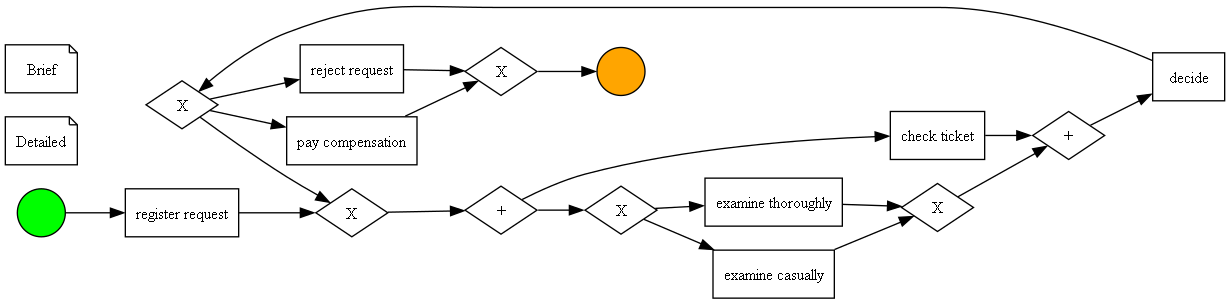

In [11]:
view(gv)

In [12]:
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.process_tree.obj import ProcessTree
from pm4py.objects.heuristics_net.obj import HeuristicsNet

In [13]:
def convert_to_petri_net(*args: Union[BPMN, ProcessTree, HeuristicsNet, dict]) -> Tuple[PetriNet, Marking, Marking]:
    if isinstance(args[0], PetriNet):
        # the object is already a Petri net
        return args[0], args[1], args[2]
    elif isinstance(args[0], ProcessTree):
        from pm4py.objects.conversion.process_tree.variants import to_petri_net
        return to_petri_net.apply(args[0])
    elif isinstance(args[0], BPMN):
        from pm4py.objects.conversion.bpmn.variants import to_petri_net
        return to_petri_net.apply(args[0])
    elif isinstance(args[0], HeuristicsNet):
        from pm4py.objects.conversion.heuristics_net.variants import to_petri_net
        return to_petri_net.apply(args[0])
    elif isinstance(args[0], dict):
        # DFG
        from pm4py.objects.conversion.dfg.variants import to_petri_net_activity_defines_place
        return to_petri_net_activity_defines_place.apply(args[0], parameters={
            to_petri_net_activity_defines_place.Parameters.START_ACTIVITIES: args[1],
            to_petri_net_activity_defines_place.Parameters.END_ACTIVITIES: args[2]})
    # if no conversion is done, then the format of the arguments is unsupported
    raise Exception("unsupported conversion of the provided object to Petri net")

In [14]:
pn, i, f = convert_to_petri_net(bp_ex)

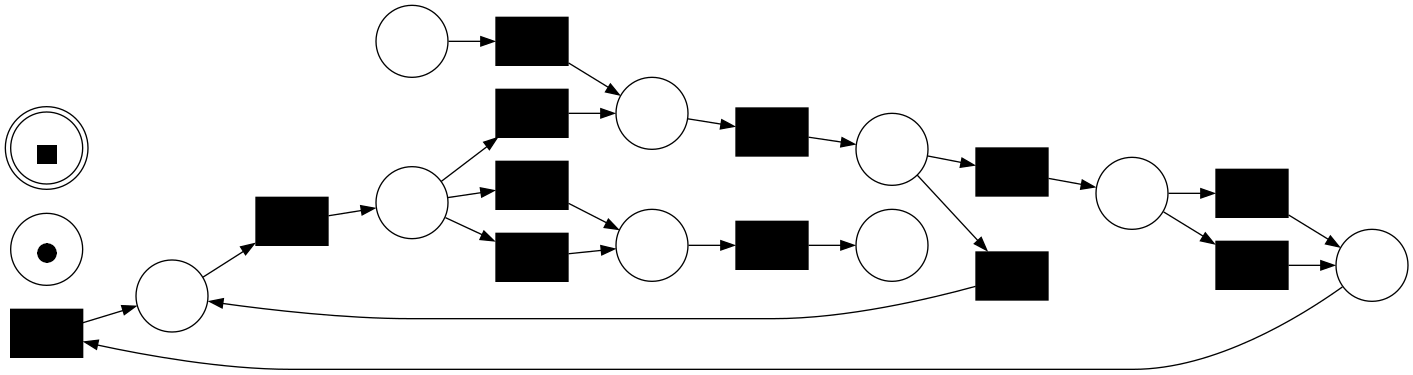

In [16]:
from pm4py.vis import view_petri_net
view_petri_net(pn, i, f)

In [ ]:

from pm4py.objects.petri_net import properties as petri_properties
def graphviz_visualization(net, image_format="png", initial_marking=None, final_marking=None, decorations=None,
                           debug=False, set_rankdir=None, font_size="12", bgcolor=constants.DEFAULT_BGCOLOR):
    if initial_marking is None:
        initial_marking = Marking()
    if final_marking is None:
        final_marking = Marking()
    if decorations is None:
        decorations = {}

    font_size = str(font_size)

    filename = tempfile.NamedTemporaryFile(suffix='.gv')
    viz = Digraph(net.name, filename=filename.name, engine='dot', graph_attr={'bgcolor': bgcolor})
    if set_rankdir:
        viz.graph_attr['rankdir'] = set_rankdir
    else:
        viz.graph_attr['rankdir'] = 'LR'

    # transitions
    viz.attr('node', shape='box')
    for t in net.transitions:
        label = decorations[t]["label"] if t in decorations and "label" in decorations[t] else ""
        fillcolor = decorations[t]["color"] if t in decorations and "color" in decorations[t] else None
        textcolor = "black"

        if t.label is not None and not label:
            label = t.label
        if debug:
            label = t.name
        label = str(label)

        if fillcolor is None:
            if t.label is None:
                fillcolor = "black"
                if label:
                    textcolor = "white"
            else:
                fillcolor = bgcolor

        viz.node(str(id(t)), label, style='filled', fillcolor=fillcolor, border='1', fontsize=font_size, fontcolor=textcolor)

        if petri_properties.TRANS_GUARD in t.properties:
            guard = t.properties[petri_properties.TRANS_GUARD]
            viz.node(str(id(t))+"guard", style="dotted", label=guard)
            viz.edge(str(id(t))+"guard", str(id(t)), arrowhead="none", style="dotted")

    # places
    # add places, in order by their (unique) name, to avoid undeterminism in the visualization
    places_sort_list_im = sorted([x for x in list(net.places) if x in initial_marking], key=lambda x: x.name)
    places_sort_list_fm = sorted([x for x in list(net.places) if x in final_marking and not x in initial_marking],
                                 key=lambda x: x.name)
    places_sort_list_not_im_fm = sorted(
        [x for x in list(net.places) if x not in initial_marking and x not in final_marking], key=lambda x: x.name)
    # making the addition happen in this order:
    # - first, the places belonging to the initial marking
    # - after, the places not belonging neither to the initial marking and the final marking
    # - at last, the places belonging to the final marking (but not to the initial marking)
    # in this way, is more probable that the initial marking is on the left and the final on the right
    places_sort_list = places_sort_list_im + places_sort_list_not_im_fm + places_sort_list_fm

    for p in places_sort_list:
        label = decorations[p]["label"] if p in decorations and "label" in decorations[p] else ""
        fillcolor = decorations[p]["color"] if p in decorations and "color" in decorations[p] else bgcolor

        label = str(label)
        if p in initial_marking:
            if initial_marking[p] == 1:
                viz.node(str(id(p)), "<&#9679;>", fontsize="34", fixedsize='true', shape="circle", width='0.75', style="filled", fillcolor=fillcolor)
            else:
                viz.node(str(id(p)), str(initial_marking[p]), fontsize="34", fixedsize='true', shape="circle", width='0.75', style="filled", fillcolor=fillcolor)
        elif p in final_marking:
            # <&#9632;>
            viz.node(str(id(p)), "<&#9632;>", fontsize="32", shape='doublecircle', fixedsize='true', width='0.75', style="filled", fillcolor=fillcolor)
        else:
            if debug:
                viz.node(str(id(p)), str(p.name), fontsize=font_size, shape="ellipse")
            else:
                if p in decorations and "color" in decorations[p] and "label" in decorations[p]:
                    viz.node(str(id(p)), label, style='filled', fillcolor=fillcolor,
                             fontsize=font_size, shape="ellipse")
                else:
                    viz.node(str(id(p)), label, shape='circle', fixedsize='true', width='0.75', style="filled", fillcolor=fillcolor)

    # add arcs, in order by their source and target objects names, to avoid undeterminism in the visualization
    arcs_sort_list = sorted(list(net.arcs), key=lambda x: (x.source.name, x.target.name))

    # check if there is an arc with weight different than 1.
    # in that case, all the arcs in the visualization should have the arc weight visible
    arc_weight_visible = False
    for arc in arcs_sort_list:
        if arc.weight != 1:
            arc_weight_visible = True
            break

    for a in arcs_sort_list:
        penwidth = decorations[a]["penwidth"] if a in decorations and "penwidth" in decorations[a] else None
        label = decorations[a]["label"] if a in decorations and "label" in decorations[a] else ""
        color = decorations[a]["color"] if a in decorations and "color" in decorations[a] else None

        if not label and arc_weight_visible:
            label = a.weight

        label = str(label)
        arrowhead = "normal"

        if petri_properties.ARCTYPE in a.properties:
            if a.properties[petri_properties.ARCTYPE] == petri_properties.RESET_ARC:
                arrowhead = "vee"
            elif a.properties[petri_properties.ARCTYPE] == petri_properties.INHIBITOR_ARC:
                arrowhead = "dot"

        viz.edge(str(id(a.source)), str(id(a.target)), label=label,
                 penwidth=penwidth, color=color, fontsize=font_size, arrowhead=arrowhead, fontcolor=color)

    viz.attr(overlap='false')

    viz.format = image_format.replace("html", "plain-ext")

    return viz

In [ ]:
graphviz_visualization(pn, initial_marking=i, final_marking=f)